In [1]:
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

from tqdm import tqdm

import numpy as np
import nibabel as nib
import concurrent.futures

from monai.data.utils import pad_list_data_collate

import monai.losses as losses
import matplotlib.pyplot as plt
from monai.networks.layers import Norm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import Transform
from monai.transforms import (
    AsDiscrete,
    Compose,
    SpatialPad,
    SpatialPadd,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandCropByLabelClassesd,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    NormalizeIntensity,
    NormalizeIntensityd,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
    RandGaussianNoised,
)


from monai.config import print_config
from monai.metrics import DiceMetric, HausdorffDistanceMetric
from monai.networks.nets import UNet

from monai.data import (
    DataLoader,
    ThreadDataLoader,
    SmartCacheDataset,
    PersistentDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, CyclicLR

from boundary_loss import BDLoss, DC_and_BD_loss

print_config()

MONAI version: 1.1.0
Numpy version: 1.21.5
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /home/emmanuel/PycharmProjects/pythonProject/venv/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.5.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: 4.7.1
TorchVision version: 0.14.1+cu117
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 1.3.5
einops version: 0.6.1
transformers version: 4.28.1
mlflow version: 1.30.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = 'Model'
model_name =  os.path.join(root_dir, "best_metric_model_with_ce_loss.pth")
print(model_name)

Model/best_metric_model_with_ce_loss.pth


In [4]:
class CombineBinaryMaps(Transform):
    def __init__(self, num_classes, keys):
        super().__init__()
        self.num_classes = num_classes

    def __call__(self, data):
        binary_maps = data["label"]
        combined_map = torch.zeros_like(data['image'][0])

        for i in range(self.num_classes):
            zero_indices = np.where(combined_map == 0)
            combined_map[zero_indices] += (i + 1) * binary_maps[i][zero_indices]
#             combined_map %= (self.num_classes + 1)

        data["label"] = combined_map.long().unsqueeze(0)
        return data

In [5]:
class MyCustomDataReader(Transform):
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def __call__(self, img):
        # Load data from the data_dir
        file_path = os.path.join(self.data_dir, img)
        loaded_data = np.load(file_path)  # Customize this to your specific data format

        return loaded_data

In [6]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ToDo: Try windowing with W:350 and L:40
# define the window width and level
window_width = 350
window_level = 40

# calculate the intensity range to clip
intensity_min = window_level - window_width / 2.0
intensity_max = window_level + window_width / 2.0

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True, image_only=False),
        CombineBinaryMaps(keys=["label"], num_classes=10),
#         RandGaussianNoised(keys=["image"], prob=0.50, mean=0.0, std=0.1),

        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(
            spatial_size=(96, 96, 96),
            keys=["image", "label"]
        ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
       
#         RandCropByLabelClassesd(
#             keys=["image", "label"],
#             label_key="label",
#             spatial_size=(96, 96, 96),
#             num_samples=num_samples,
#             num_classes=11,
#             image_key="image",
#             image_threshold=0,
#             allow_smaller=True
#         ),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
            allow_smaller=True
        ),

        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True, image_only=False),
        CombineBinaryMaps(keys=["label"], num_classes=10),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),
        SpatialPadd(
            spatial_size=(96, 96, 96),
            keys=["image", "label"]
        ),
        EnsureTyped(keys=["image", "label"], device='cpu', track_meta=True),
    ]
)

# Load Dataset

In [7]:
def generate_file_path(root_path):
    all_files = os.listdir(root_path)
    return [{'image': f'{root_path}/{i}/ct.nii.gz',
             'label': [f'{root_path}/{i}/segments/{f}' for f in os.listdir(f'{root_path}/{i}/segments')],
#              'label': f'{root_path}/{i}/labels.nii.gz'

            } 
            for i in all_files if os.path.isfile(f'{root_path}/{i}/ct.nii.gz')]

def data_reader(file_addr):
    # load the image data
    image_read = nib.load(item["image"])
    image_data = image_read.get_fdata(dtype=np.float32)
    header = image_read.header
    # load the label data
    label_data = nib.load(item["label"]).get_fdata(dtype=np.float32)
    # Extract the metadata from the header
    metadata = {'dim': header.get_data_shape(),
                'pixdim': header.get_zooms(),
                'affine': header.get_qform()}
    data = {
        'image': image_data,
        'label': label_data,
        'metadata': metadata,
    }
    return data

In [8]:
root = 'Dataset'
file_list_train = generate_file_path(root_path=f'{root}/train')
file_list_val = generate_file_path(root_path=f'{root}/val')

In [9]:
def collate_fn(batch):
    transform = SpatialPad(
            (96, 96, 96),
        )
#     print([item for item in batch[0]])
    images = [transform(item["image"]) for item in batch[0]]
    labels = [transform(item["label"]) for item in batch[0]]
#     print(images.shape, labels.shape)
    return {"image": torch.stack(images),
           "label":torch.stack(labels)}

In [10]:
train_ds = PersistentDataset(
    data=file_list_train,
    transform=train_transforms,
    cache_dir='train_unet'
)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True,
                                collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96))
                               )

In [11]:
val_ds = PersistentDataset(
    data=file_list_val,
    transform=val_transforms,
    cache_dir='val'
#     cache_dir='C:/Training/val'
)

val_loader = DataLoader(val_ds, batch_size=1, 
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

# Model

In [12]:
class EarlyStopping:
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        else:
            if (self.best_loss - loss) > self.min_delta:
                self.best_loss = loss
                self.counter = 0
            else:
                self.counter += 1
                print(f'Early Stopping patience: {self.counter}, best loss: {self.best_loss}, current_loss: {loss}')
                if self.counter >= self.tolerance:  
                    self.early_stop = True

In [13]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"Number of available GPUs: {device_count}")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU found, using CPU instead.")

Number of available GPUs: 1
GPU 0: GeForce RTX 2080 Ti


In [14]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = UNet(
              spatial_dims=3,
              in_channels=1,
              out_channels=11,
              channels=(16, 32, 64, 128, 256),
              strides=(2, 2, 2, 2),
              num_res_units=2,
              norm=Norm.BATCH
                ).to(device)

cuda


In [15]:
torch.backends.cudnn.benchmark = True
early_stopping = EarlyStopping(tolerance=10, min_delta=0.001)
loss_function = DiceCELoss(to_onehot_y=True, softmax=True, lambda_dice=1, lambda_ce=1)
bd_loss =  BDLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, patience=10, verbose=True, mode='min', min_lr=1e-8, factor=0.9)
scaler = torch.cuda.amp.GradScaler()

In [16]:
transform = SpatialPad(
            (1, 96, 96, 96),
        )
def validation(epoch_iterator_val):
    model.eval()
    model.to('cpu')
    validation_loss = []
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cpu(), batch["label"].cpu())
#             with torch.cuda.amp.autocast():
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), num_samples, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            loss = loss_function(val_outputs, val_labels)
            validation_loss.append(loss.item())
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description(f"Validate (loss={loss.item():2.5f})")
#             break
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
#         val_inputs, val_labels = val_inputs.cpu(), val_labels.cpu()
        mean_hausdorff = 0

        validation_loss_mean = np.nanmean(np.nan_to_num(np.array(validation_loss),
                                               nan=np.nan, posinf=np.nan, neginf=np.nan))

        val_loss_values.append(validation_loss_mean)
    return mean_dice_val, mean_hausdorff, validation_loss_mean


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    model.to(device)
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
#         print(step)
        x, y = (batch["image"].cuda(), batch["label"].cuda())
#         a = all(t.shape == x.shape for t in y)
        if x.shape != y.shape:
            print(x.shape, y.shape)
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        if torch.isnan(loss):
            print(torch.max(x), torch.min(x))
            
        scaler.unscale_(optimizer)

        scaler.step(optimizer)

        scaler.update()
        optimizer.zero_grad()

        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss.item():2.5f})")
        global_step += 1
#         break
       

    epoch_loss /= step
    return global_step, dice_val_best, global_step_best, epoch_loss

In [17]:
max_iterations = 90000

post_label = AsDiscrete(to_onehot=11)
post_pred = AsDiscrete(argmax=True, to_onehot=11)

dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
hausdorff_metric = HausdorffDistanceMetric(include_background=True, get_not_nans=False, reduction="none",
                                           distance_metric="euclidean")
# remove this section future run
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
val_loss_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best, epoch_loss = train(global_step, train_loader, dice_val_best, global_step_best)
    epoch_iterator_val = tqdm(val_loader, desc="Validate", dynamic_ncols=True)
    dice_val, hausdorff_val, loss_val = validation(epoch_iterator_val)
    scheduler.step(epoch_loss)
    epoch_loss_values.append(epoch_loss)
    metric_values.append(dice_val)
    early_stopping(loss_val)
    print(f'Mean Hausdorff disatnce: {hausdorff_val}')
    if dice_val > dice_val_best:
        dice_val_best = dice_val
        global_step_best = global_step
        torch.save(model.state_dict(), model_name)
        print(
            "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
        )
    else:
        print(
            "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                dice_val_best, dice_val
            )
        )
    # early stopping
    if early_stopping.early_stop:
        break
        
model.load_state_dict(torch.load(model_name))

Validate (loss=1.08222): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:08<00:00, 10.37s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.2448105812072754 Current Avg. Dice: 0.2448105812072754


Validate (loss=0.88974): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:10<00:00, 10.44s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.3502560555934906 Current Avg. Dice: 0.3502560555934906


Validate (loss=0.80037): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:03<00:00, 10.16s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.40278756618499756 Current Avg. Dice: 0.40278756618499756


Validate (loss=0.74820): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:03<00:00, 10.14s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.4709209203720093 Current Avg. Dice: 0.4709209203720093


Validate (loss=0.66364): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.21s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.4904846251010895 Current Avg. Dice: 0.4904846251010895


Validate (loss=0.65812): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:04<00:00, 10.17s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.5625076293945312 Current Avg. Dice: 0.5625076293945312


Validate (loss=0.51975): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:04<00:00, 10.19s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.6670276522636414 Current Avg. Dice: 0.6670276522636414


Validate (loss=0.40027): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.25s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7014080882072449 Current Avg. Dice: 0.7014080882072449


Validate (loss=0.42079): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:06<00:00, 10.27s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.708794891834259 Current Avg. Dice: 0.708794891834259


Validate (loss=0.32055): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.21s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.7734289765357971 Current Avg. Dice: 0.7734289765357971


Validate (loss=0.32663): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:07<00:00, 10.31s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8020340800285339 Current Avg. Dice: 0.8020340800285339


Validate (loss=0.26869): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:07<00:00, 10.29s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8169494271278381 Current Avg. Dice: 0.8169494271278381


Validate (loss=0.30446): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:07<00:00, 10.30s/it]


Early Stopping patience: 1, best loss: 0.37616465613245964, current_loss: 0.398872222751379
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8169494271278381 Current Avg. Dice: 0.7988057136535645


Validate (loss=0.22479): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:07<00:00, 10.33s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8341140747070312 Current Avg. Dice: 0.8341140747070312


Validate (loss=0.21693): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.24s/it]


Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8341140747070312 Current Avg. Dice: 0.8295733332633972


Validate (loss=0.18019): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:07<00:00, 10.29s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8347296714782715 Current Avg. Dice: 0.8347296714782715


Validate (loss=0.17983): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.24s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8419302105903625 Current Avg. Dice: 0.8419302105903625


Validate (loss=0.20785): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.24s/it]


Early Stopping patience: 1, best loss: 0.2981278946002324, current_loss: 0.3261726877341668
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8419302105903625 Current Avg. Dice: 0.8303120136260986


Validate (loss=0.18272): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.22s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8508481383323669 Current Avg. Dice: 0.8508481383323669


Validate (loss=0.17504): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:04<00:00, 10.20s/it]


Early Stopping patience: 1, best loss: 0.2845931127667427, current_loss: 0.29082705453038216
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8508481383323669 Current Avg. Dice: 0.848125159740448


Validate (loss=0.15970): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.23s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8609468936920166 Current Avg. Dice: 0.8609468936920166


Validate (loss=0.16830): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.25s/it]


Early Stopping patience: 1, best loss: 0.2637401533623536, current_loss: 0.26375977757076424
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8609468936920166 Current Avg. Dice: 0.8554174304008484


Validate (loss=0.17016): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.21s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8691990971565247 Current Avg. Dice: 0.8691990971565247


Validate (loss=0.16144): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:06<00:00, 10.27s/it]


Early Stopping patience: 1, best loss: 0.25666111521422863, current_loss: 0.2663983752330144
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8691990971565247 Current Avg. Dice: 0.8598520159721375


Validate (loss=0.16053): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:08<00:00, 10.34s/it]


Early Stopping patience: 2, best loss: 0.25666111521422863, current_loss: 0.26001260926326114
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8691990971565247 Current Avg. Dice: 0.8580029010772705


Validate (loss=0.13030): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.23s/it]


Early Stopping patience: 3, best loss: 0.25666111521422863, current_loss: 0.25748278635243577
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8691990971565247 Current Avg. Dice: 0.8586651682853699


Validate (loss=0.12875): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:04<00:00, 10.19s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8756491541862488 Current Avg. Dice: 0.8756491541862488


Validate (loss=0.22460): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:04<00:00, 10.20s/it]


Early Stopping patience: 1, best loss: 0.23988657289495072, current_loss: 0.3045253275583188
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8756491541862488 Current Avg. Dice: 0.8217137455940247


Validate (loss=0.11619): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.24s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8766011595726013 Current Avg. Dice: 0.8766011595726013


Validate (loss=0.11875): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.21s/it]


Early Stopping patience: 1, best loss: 0.2358646597713232, current_loss: 0.25340898148715496
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8766011595726013 Current Avg. Dice: 0.8603236675262451


Validate (loss=0.13036): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.24s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8782525062561035 Current Avg. Dice: 0.8782525062561035


Validate (loss=0.14124): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.21s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8803779482841492 Current Avg. Dice: 0.8803779482841492


Validate (loss=0.12181): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.21s/it]


Early Stopping patience: 1, best loss: 0.22365332829455534, current_loss: 0.232127389870584
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8803779482841492 Current Avg. Dice: 0.8779775500297546


Validate (loss=0.10599): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:06<00:00, 10.26s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8901250958442688 Current Avg. Dice: 0.8901250958442688


Validate (loss=0.11057): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:06<00:00, 10.27s/it]


Early Stopping patience: 1, best loss: 0.20796850137412548, current_loss: 0.21056911473472914
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8908461928367615 Current Avg. Dice: 0.8908461928367615


Validate (loss=0.10866): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:04<00:00, 10.21s/it]


Early Stopping patience: 2, best loss: 0.20796850137412548, current_loss: 0.2072699125856161
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8908461928367615 Current Avg. Dice: 0.8881245255470276


Validate (loss=0.11638): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.21s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.8941600322723389 Current Avg. Dice: 0.8941600322723389


Validate (loss=0.10351): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.22s/it]


Early Stopping patience: 1, best loss: 0.19911465886980295, current_loss: 0.20771685925622782
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8941600322723389 Current Avg. Dice: 0.8880138397216797


Validate (loss=0.10243): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:07<00:00, 10.33s/it]


Early Stopping patience: 2, best loss: 0.19911465886980295, current_loss: 0.20154118134329715
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8941600322723389 Current Avg. Dice: 0.8937191963195801


Validate (loss=0.09813): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.23s/it]


Early Stopping patience: 3, best loss: 0.19911465886980295, current_loss: 0.20964330372711024
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.8941600322723389 Current Avg. Dice: 0.8889120221138


Validate (loss=0.09741): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.23s/it]


Early Stopping patience: 4, best loss: 0.19911465886980295, current_loss: 0.2066477993503213
Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.894263505935669 Current Avg. Dice: 0.894263505935669


Validate (loss=0.09785): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.21s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.899139404296875 Current Avg. Dice: 0.899139404296875


Validate (loss=0.12094): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.23s/it]


Early Stopping patience: 1, best loss: 0.19427872387071451, current_loss: 0.23683518450707197
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.899139404296875 Current Avg. Dice: 0.8631507754325867


Validate (loss=0.09543): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.24s/it]


Early Stopping patience: 2, best loss: 0.19427872387071451, current_loss: 0.1977738318964839
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.899139404296875 Current Avg. Dice: 0.8943760991096497


Validate (loss=0.09319): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:06<00:00, 10.25s/it]


Early Stopping patience: 3, best loss: 0.19427872387071451, current_loss: 0.19577937045445046
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.899139404296875 Current Avg. Dice: 0.8946168422698975


Validate (loss=0.08831): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:04<00:00, 10.19s/it]


Early Stopping patience: 4, best loss: 0.19427872387071451, current_loss: 0.19619120657444
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.899139404296875 Current Avg. Dice: 0.8934187293052673


Validate (loss=0.10663): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:06<00:00, 10.29s/it]


Early Stopping patience: 5, best loss: 0.19427872387071451, current_loss: 0.20052860646198192
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.899139404296875 Current Avg. Dice: 0.8952586650848389


Validate (loss=0.09467): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:06<00:00, 10.25s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.904628574848175 Current Avg. Dice: 0.904628574848175


Validate (loss=0.09546): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.22s/it]


Early Stopping patience: 1, best loss: 0.1819490436464548, current_loss: 0.19713371247053146
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.904628574848175 Current Avg. Dice: 0.896129846572876


Validate (loss=0.10026): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.24s/it]


Early Stopping patience: 2, best loss: 0.1819490436464548, current_loss: 0.183902895078063
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.904628574848175 Current Avg. Dice: 0.9034572243690491


Validate (loss=0.09162): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:06<00:00, 10.26s/it]


Early Stopping patience: 3, best loss: 0.1819490436464548, current_loss: 0.18525463591019312
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.904628574848175 Current Avg. Dice: 0.8990073800086975


Validate (loss=0.09957): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:06<00:00, 10.27s/it]


Early Stopping patience: 4, best loss: 0.1819490436464548, current_loss: 0.1968339333931605
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.904628574848175 Current Avg. Dice: 0.8938425183296204


Validate (loss=0.09064): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.21s/it]


Mean Hausdorff disatnce: 0
Model Was Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.9074835777282715


Validate (loss=0.09696): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:04<00:00, 10.20s/it]


Early Stopping patience: 1, best loss: 0.17646410533537468, current_loss: 0.19456137406329313
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.8926157355308533


Validate (loss=0.09308): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.24s/it]


Early Stopping patience: 2, best loss: 0.17646410533537468, current_loss: 0.18459262885153294
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.9003004431724548


Validate (loss=0.09860): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.22s/it]


Early Stopping patience: 3, best loss: 0.17646410533537468, current_loss: 0.19483806223918995
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.8950290679931641


Validate (loss=0.10759): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:04<00:00, 10.20s/it]


Early Stopping patience: 4, best loss: 0.17646410533537468, current_loss: 0.1856952120239536
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.9030911326408386


Validate (loss=0.09785): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.23s/it]


Early Stopping patience: 5, best loss: 0.17646410533537468, current_loss: 0.18042332554856935
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.9030213952064514


Validate (loss=0.09428): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.22s/it]


Early Stopping patience: 6, best loss: 0.17646410533537468, current_loss: 0.1805195833245913
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.902592122554779


Validate (loss=0.09527): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.23s/it]


Early Stopping patience: 7, best loss: 0.17646410533537468, current_loss: 0.19535860046744347
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.8946418762207031


Validate (loss=0.09441): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.22s/it]


Early Stopping patience: 8, best loss: 0.17646410533537468, current_loss: 0.18632051845391592
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.8999964594841003


Validate (loss=0.08322): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:06<00:00, 10.28s/it]


Early Stopping patience: 9, best loss: 0.17646410533537468, current_loss: 0.17930772186567387
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.9038634300231934


Validate (loss=0.09438): 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [04:05<00:00, 10.25s/it]

Early Stopping patience: 10, best loss: 0.17646410533537468, current_loss: 0.18289615120738745
Mean Hausdorff disatnce: 0
Model Was Not Saved ! Current Best Avg. Dice: 0.9074835777282715 Current Avg. Dice: 0.9021614193916321


<All keys matched successfully>

In [18]:
# epoch_iterator_val = tqdm(val_loader, desc="Validate", dynamic_ncols=True)
# for batch in epoch_iterator_val:
#  print(1)   

In [19]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

train completed, best_metric: 0.9075 at iteration: 18921


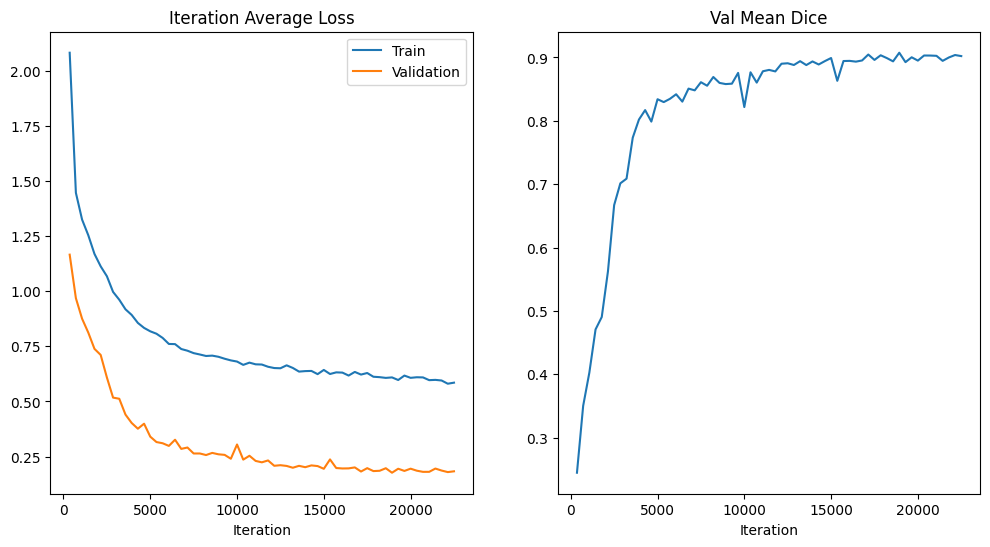

In [20]:
eval_num = 357
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y, label='Train')
x = [eval_num * (i + 1) for i in range(len(val_loss_values))]
y = val_loss_values
plt.plot(x, y, label='Validation')
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

In [ ]:
model_name =  os.path.join(root_dir, "best_metric_model_with_ce_loss.pth")

model.load_state_dict(torch.load(model_name))
model.eval()

In [ ]:
case_num = 4
with torch.no_grad():
    model.to('cpu')
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cpu()
    val_labels = torch.unsqueeze(label, 1).cpu()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), num_samples, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 200], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 200])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 200])
    plt.show()

In [ ]:
file_list_test = generate_file_path(root_path=f'{root}/test')
test_ds = PersistentDataset(
    data=file_list_test,
    transform=val_transforms,
    cache_dir='test'
#     cache_dir='C:/Training/val'
)

test_loader = ThreadDataLoader(test_ds, num_workers=0, batch_size=1, 
                              collate_fn=lambda x: pad_list_data_collate(x, pad_to_shape=(96, 96, 96)))

In [ ]:
def test(epoch_iterator_test):
    model.eval()
    test_loss = []
    with torch.no_grad():
        for batch in epoch_iterator_test:
            test_inputs, test_labels = (batch["image"].cpu(), batch["label"].cpu())
            with torch.cuda.amp.autocast():
#                 test_outputs = sliding_window_inference(test_inputs, (96, 96, 96), num_samples, model, overlap=0.8)
                test_outputs = sliding_window_inference(test_inputs, (96, 96, 96), num_samples, model)
            test_labels_list = decollate_batch(test_labels)
            test_labels_convert = [post_label(test_label_tensor) for test_label_tensor in test_labels_list]
            test_outputs_list = decollate_batch(test_outputs)
            test_output_convert = [post_pred(test_pred_tensor) for test_pred_tensor in test_outputs_list]
            loss = loss_function(test_outputs, test_labels)
            test_loss.append(loss.item())
            dice_metric(y_pred=test_output_convert, y=test_labels_convert)
            epoch_iterator_test.set_description(f"Test (loss={loss.item():2.5f})")
        mean_dice_test = dice_metric.aggregate()
        dice_metric.reset()

        test_loss_mean = np.nanmean(np.nan_to_num(np.array(test_loss),
                                               nan=np.nan, posinf=np.nan, neginf=np.nan))
    return mean_dice_test, test_loss_mean

In [ ]:
post_label = AsDiscrete(to_onehot=11)
post_pred = AsDiscrete(argmax=True, to_onehot=11)
dice_metric = DiceMetric(include_background=True, reduction='none', get_not_nans=False)
epoch_iterator_test = tqdm(test_loader, desc="Test", dynamic_ncols=True)
dice_test, loss_test = test(epoch_iterator_test)

In [31]:
print(f'Test: (loss={loss_test}) (dice={dice_test})')

Test: (loss=0.18206769496202468) (dice=0.9056133031845093)
